<a href="https://colab.research.google.com/github/errorcodecritical/JupyterML/blob/main/Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Room Occupancy Estimation using Machine Learning

## Introduction

This notebook aims to analyze and develop machine learning models for **Room Occupancy Estimation** using non-intrusive environmental sensors such as **temperature, light, sound, CO2, and PIR (Passive Infrared)**. The goal is to predict the number of occupants in a room based on sensor data.

This project is developed as part of the **Machine Learning Challenge (Aprendizagem Computacional), 2025** at **DEI, FCT, University of Coimbra**. The objective of the challenge is to identify a real-world classification problem, apply simple machine learning models, and evaluate their effectiveness.

## Dataset Information

The dataset used in this project is [**Room Occupancy Estimation**](https://archive.ics.uci.edu/dataset/864/room+occupancy+estimation), which consists of **10129 instances and 18 features**. The data was collected over four days in a controlled environment, where occupancy varied between **0 and 3 people**.

- **Sensor Types Used:**
  - **Temperature**
  - **Light**
  - **Sound**
  - **CO2**
  - **Passive Infrared (PIR)**

- **Experimental Setup:**
  - Data was collected in a **6m x 4.6m room**.
  - **7 sensor nodes** were deployed, transmitting data every **30 seconds**.
  - The PIR, CO2, and sound sensors required manual calibration.
  - The ground truth was manually recorded.

## Challenge Goals

The primary goals of this challenge are:
1. **Problem Identification:** Understand how environmental sensor data can be used for room occupancy estimation.
2. **Data Analysis:** Explore the dataset, clean, and preprocess it.
3. **Model Construction:** Implement at least **two simple machine learning models** (e.g., Decision Trees, K-Nearest Neighbors, Logistic Regression).
4. **Evaluation Metrics:** Assess model performance using appropriate evaluation metrics.
5. **Documentation & Submission:** Record findings, methodologies, and challenges faced.

## Next Steps

1. Load and preprocess the dataset.
2. Perform exploratory data analysis (EDA).
3. Train and evaluate machine learning models.
4. Compare model performance using visualization tools.

---

# Dataset Column Descriptions
| **Feature/Target**    | **Type**       | **Description**                                              | **Units**      |
|-------------------------|---------------|--------------------------------------------------------------|---------------|
| `Date`                 | Date          | Date when the data was recorded                              | YYYY/MM/DD    |
| `Time`                 | Time          | Time when the data was recorded                              | HH:MM:SS      |
| `S1_Temp` – `S4_Temp`  | Continuous    | Ambient temperature measured at different sensor locations   | °C            |
| `S1_Light` – `S4_Light`| Integer       | Light intensity measured at different sensor locations       | Lux           |
| `S1_Sound` – `S4_Sound`| Continuous    | Sound levels measured using an amplifier output read by ADC  | Volts         |
| `S5_CO2`              | Integer       | Carbon dioxide (CO2) concentration in the room              | PPM           |
| `S5_CO2_Slope`       | Continuous    | Rate of change (slope) of CO2 concentration over time       | -             |
| `S6_PIR`, `S7_PIR`    | Binary/Integer | Motion detection using Passive Infrared (PIR) sensors       | - (0 = No motion, 1 = Motion detected) |
| `Room_Occupancy_Count` | Integer        | Ground truth number of occupants in the room                | -             |


**NOTE:** There are no missing (null) values in the dataset.

Install Required Libs: pip install scikit-learn pandas numpy scipy matplotlib seaborn

For report:
- DETERMINE PROBLEM, SOLUTION, OBJECTIVE;
- BREAKDOWN OF THE DATASET, DESCRIPTION OF VARIABLES AND TARGETS, NUMBER OF NULL VALUES 

In [1]:
import pandas as pd
from ucimlrepo import fetch_ucirepo

#Converts hours, minutes, seconds to seconds for easier handling

def hms_to_seconds(t):
    h, m, s = [int(i) for i in str(t).split(':')]
    return 3600*h + 60*m + s
  
# fetch dataset 
room_occupancy_estimation = fetch_ucirepo(id=864) 
  
# data (as pandas dataframes) 
X = room_occupancy_estimation.data.features
y = room_occupancy_estimation.data.targets

# Get dataset information


# Get number of target elements of the same category
target_distribution = y.pivot_table(index=["Room_Occupancy_Count"], aggfunc="size")

# We can see the dataset is unbalanced. Ruh-roh!
X.iloc[:,1]

# time_in_seconds = hms_to_seconds(X.iloc[:, 1])
#room_occupancy_estimation(room_occupancy_estimation.loc["Date"])

0        10:49:41
1        10:50:12
2        10:50:42
3        10:51:13
4        10:51:44
           ...   
10124    08:58:07
10125    08:58:37
10126    08:59:08
10127    08:59:39
10128    09:00:09
Name: Time, Length: 10129, dtype: object

In [2]:
# Example of data entries
X.join(y).head()

,Date,Time,S1_Temp,S2_Temp,S3_Temp,S4_Temp,S1_Light,S2_Light,S3_Light,S4_Light,S1_Sound,S2_Sound,S3_Sound,S4_Sound,S5_CO2,S5_CO2_Slope,S6_PIR,S7_PIR,Room_Occupancy_Count
0,2017/12/22,10:49:41,24.94,24.75,24.56,25.38,121,34,53,40,0.08,0.19,0.06,0.06,390,0.769231,0,0,1
1,2017/12/22,10:50:12,24.94,24.75,24.56,25.44,121,33,53,40,0.93,0.05,0.06,0.06,390,0.646154,0,0,1
2,2017/12/22,10:50:42,25.00,24.75,24.50,25.44,121,34,53,40,0.43,0.11,0.08,0.06,390,0.519231,0,0,1
3,2017/12/22,10:51:13,25.00,24.75,24.56,25.44,121,34,53,40,0.41,0.10,0.10,0.09,390,0.388462,0,0,1
4,2017/12/22,10:51:44,25.00,24.75,24.56,25.44,121,34,54,40,0.18,0.06,0.06,0.06,390,0.253846,0,0,1


In [3]:
X.describe()

,S1_Temp,S2_Temp,S3_Temp,S4_Temp,S1_Light,S2_Light,S3_Light,S4_Light,S1_Sound,S2_Sound,S3_Sound,S4_Sound,S5_CO2,S5_CO2_Slope,S6_PIR,S7_PIR
count,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000,10129.00000,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000
mean,25.454012,25.546059,25.056621,25.754125,25.445059,26.01629,34.248494,13.220259,0.168178,0.120066,0.158119,0.103840,460.860401,-0.004830,0.090137,0.079574
std,0.351351,0.586325,0.427283,0.356434,51.011264,67.30417,58.400744,19.602219,0.316709,0.266503,0.413637,0.120683,199.964940,1.164990,0.286392,0.270645
min,24.940000,24.750000,24.440000,24.940000,0.000000,0.00000,0.000000,0.000000,0.060000,0.040000,0.040000,0.050000,345.000000,-6.296154,0.000000,0.000000
25%,25.190000,25.190000,24.690000,25.440000,0.000000,0.00000,0.000000,0.000000,0.070000,0.050000,0.060000,0.060000,355.000000,-0.046154,0.000000,0.000000
50%,25.380000,25.380000,24.940000,25.750000,0.000000,0.00000,0.000000,0.000000,0.080000,0.050000,0.060000,0.080000,360.000000,0.000000,0.000000,0.000000
75%,25.630000,25.630000,25.380000,26.000000,12.000000,14.00000,50.000000,22.000000,0.080000,0.060000,0.070000,0.100000,465.000000,0.000000,0.000000,0.000000
max,26.380000,29.000000,26.190000,26.560000,165.000000,258.00000,280.000000,74.000000,3.880000,3.440000,3.670000,3.400000,1270.000000,8.980769,1.000000,1.000000


Room_Occupancy_Count
0    8228
1     459
2     748
3     694
dtype: int64


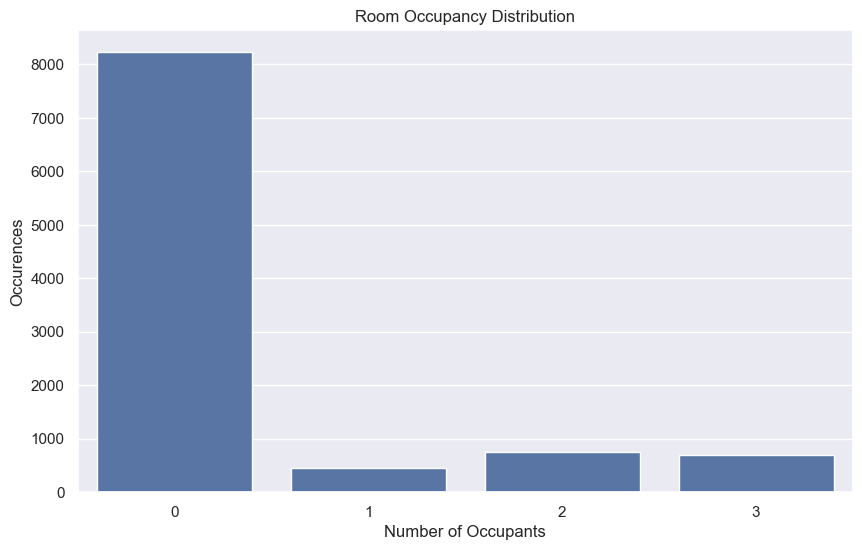

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

print(target_distribution)

# Set a theme for Seaborn plots
sns.set_theme()

# Histogram of "Room_Occupancy_Count"
plt.figure(figsize=(10, 6))
sns.barplot(x=["0", "1", "2", "3"], y=target_distribution.values)
plt.title("Room Occupancy Distribution")
plt.xlabel("Number of Occupants")
plt.ylabel("Occurences")
plt.show()

# We can see the dataset is unbalanced. Ruh-roh!

## EDA - Exploration Data Analysis

1. Remove rows with missing data - since there are no null values in the dataset, this step can be skipped.
2. Remove duplicate rows. Notice how the duplicate data is (mostly) constrained to late night / early mornings when the room is empty.

In [5]:
# Create a list of strictly numeric feature names
numeric_features = X.select_dtypes(include="number").columns.tolist()

# Count and remove duplicates
mask_duplicates = X.duplicated(subset=numeric_features, keep="first")
count_duplicates = mask_duplicates.sum()

print(count_duplicates)

X1 = X.drop_duplicates(subset=numeric_features).select_dtypes(include="number")
y1 = y[~mask_duplicates]

1301


Room_Occupancy_Count
0    6927
1     459
2     748
3     694
dtype: int64


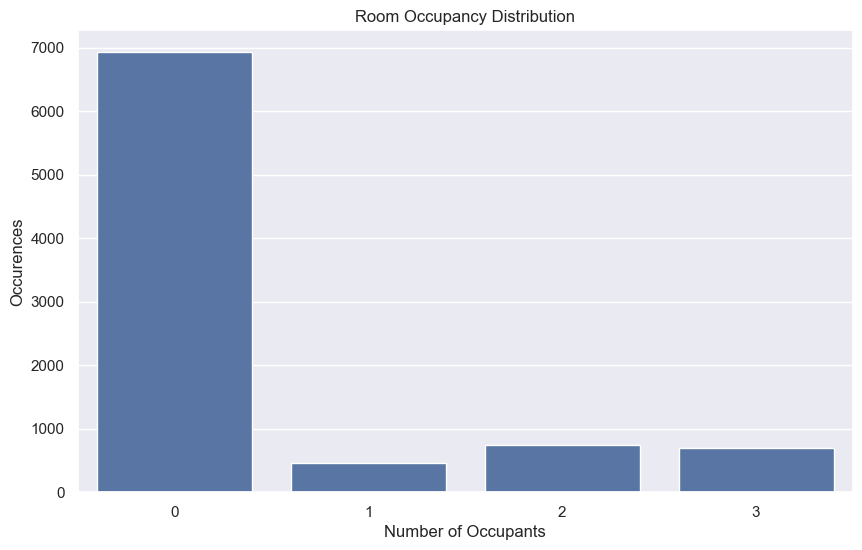

In [6]:
# Updated "Room_Occupancy_Count" after removing duplicates
target_distribution = y1.pivot_table(index=["Room_Occupancy_Count"], aggfunc="size")

print(target_distribution)

plt.figure(figsize=(10, 6))
sns.barplot(x=["0", "1", "2", "3"], y=target_distribution.values)
plt.title("Room Occupancy Distribution")
plt.xlabel("Number of Occupants")
plt.ylabel("Occurences")
plt.show()

/tmp/ipykernel_144752/3350848456.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=X["Hour"], y=y["Room_Occupancy_Count"], palette="coolwarm")


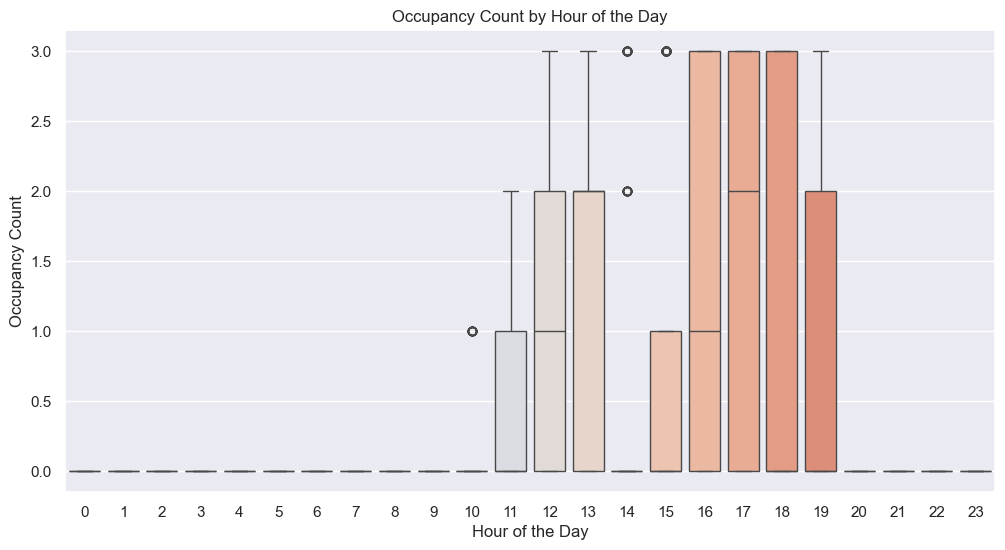

In [7]:
X["DateTime"] = pd.to_datetime(X["Date"] + " " + X["Time"])
X["Hour"] = X["DateTime"].dt.hour

# Plot occupancy by hour
plt.figure(figsize=(12,6))
sns.boxplot(x=X["Hour"], y=y["Room_Occupancy_Count"], palette="coolwarm")
plt.title("Occupancy Count by Hour of the Day")
plt.xlabel("Hour of the Day")
plt.ylabel("Occupancy Count")
plt.show()

## Grouped Univariate Visualization

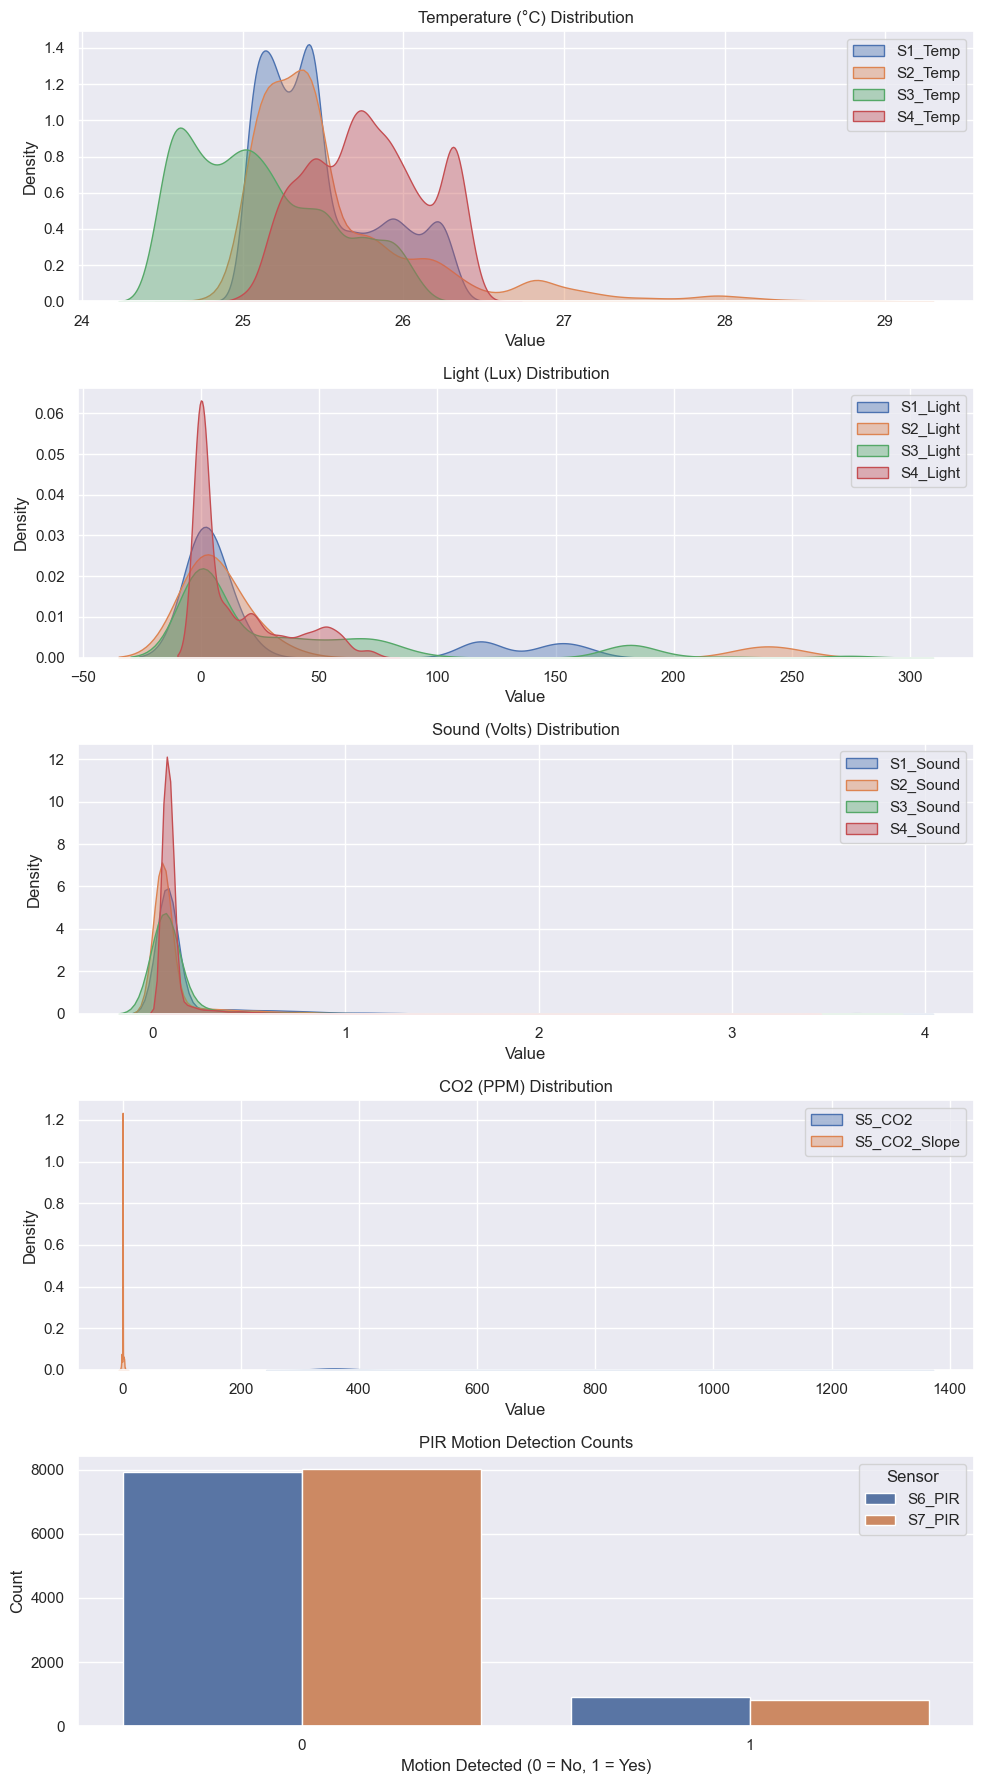

In [16]:
# Grouping sensor variables
sensor_groups = {
    "Temperature (°C)": ["S1_Temp", "S2_Temp", "S3_Temp", "S4_Temp"],
    "Light (Lux)": ["S1_Light", "S2_Light", "S3_Light", "S4_Light"],
    "Sound (Volts)": ["S1_Sound", "S2_Sound", "S3_Sound", "S4_Sound"],
    "CO2 (PPM)": ["S5_CO2", "S5_CO2_Slope"],
}

# Plot continuous variables with KDE plots
fig, axes = plt.subplots(len(sensor_groups) + 1, 1, figsize=(10, 18))  # Extra subplot for PIR
for ax, (group_name, features) in zip(axes[:-1], sensor_groups.items()):
    for feature in features:
        sns.kdeplot(X1[feature], ax=ax, label=feature, fill=True, alpha=0.4)
    
    ax.set_title(f"{group_name} Distribution")
    ax.legend()
    ax.set_xlabel("Value")
    ax.set_ylabel("Density")

# Separate plot for PIR Motion (binary data) using bar plots
ax_pir = axes[-1]
pir_data = X1[["S6_PIR", "S7_PIR"]].melt(var_name="Sensor", value_name="Value")
sns.countplot(x="Value", hue="Sensor", data=pir_data, ax=ax_pir)

ax_pir.set_title("PIR Motion Detection Counts")
ax_pir.set_xlabel("Motion Detected (0 = No, 1 = Yes)")
ax_pir.set_ylabel("Count")
ax_pir.legend(title="Sensor")

plt.tight_layout()
plt.show()


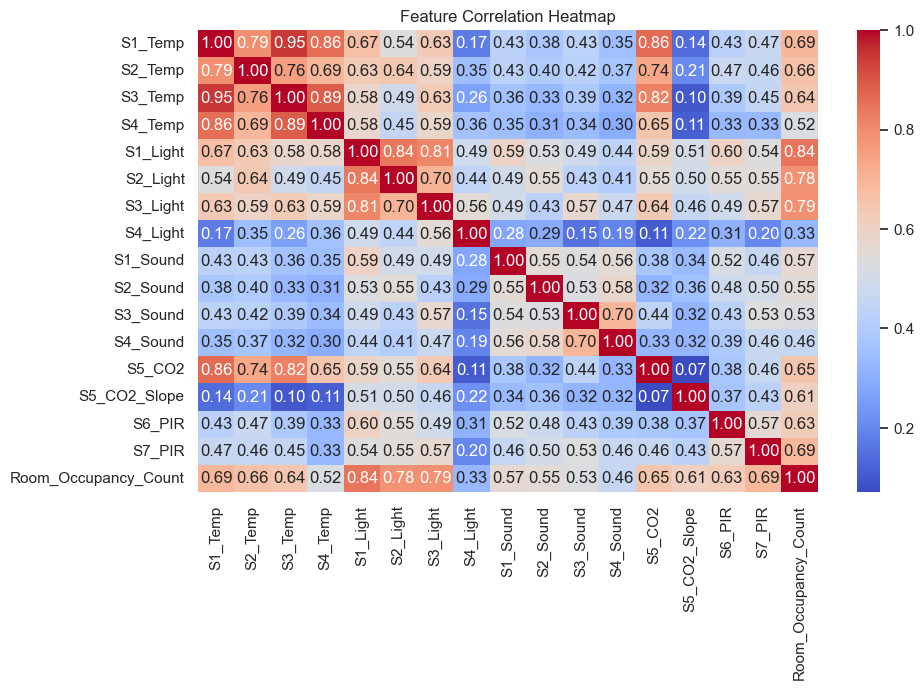

In [9]:
X1y1 = X1.join(y1)

plt.figure(figsize=(10, 6))
sns.heatmap(X1y1.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

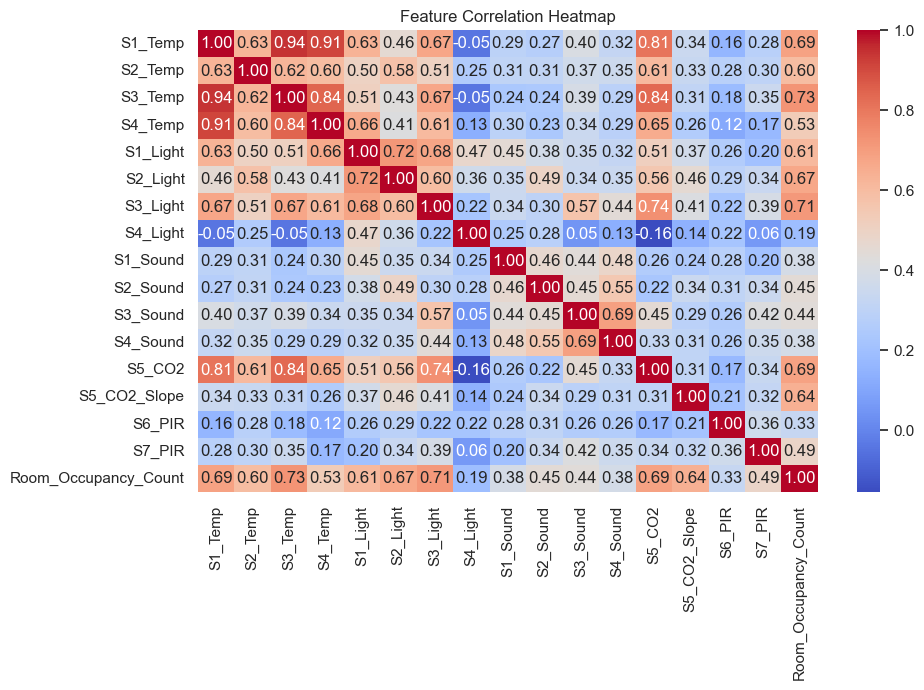

In [10]:
# Random undersampling removes a significant number of majority class samples, which can lead to a loss of valuable information.
# We use SMOTE in order to preserve the existing tendencies of the minority class samples.

from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy="auto", random_state=42)
X_resampled, y_resampled = smote.fit_resample(X1, y1)

X1y1 = X_resampled.join(y_resampled)

plt.figure(figsize=(10, 6))
sns.heatmap(X1y1.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()